# Exploratory analysis on the dataset

### Import libraries and load dataset

In [100]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from PIL import Image

In [101]:
datafile_path = "/kaggle/input/lung-tumor-ds/dataset_lung.xlsx"
dataset = pd.read_excel(datafile_path)

In [102]:
print("Dataset Preview:")
print(dataset.head())

print("\nDataset Info:")
print(dataset.info())
print("\nMissing Values:")
print(dataset.isnull().sum())
print("\nDuplicated Entries:", dataset.duplicated().sum())

Dataset Preview:
            Full_slice            Nodule  TumorClass
0  pat1_fullslice.nrrd  pat1_nodule.nrrd           5
1  pat2_fullslice.nrrd  pat2_nodule.nrrd           5
2  pat3_fullslice.nrrd  pat3_nodule.nrrd           2
3  pat4_fullslice.nrrd  pat4_nodule.nrrd           5
4  pat5_fullslice.nrrd  pat5_nodule.nrrd           4

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Full_slice  2363 non-null   object
 1   Nodule      2363 non-null   object
 2   TumorClass  2363 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 55.5+ KB
None

Missing Values:
Full_slice    0
Nodule        0
TumorClass    0
dtype: int64

Duplicated Entries: 0


### Visualize class distribution


Class Distribution:
TumorClass
3    1092
2     457
4     418
1     244
5     152
Name: count, dtype: int64


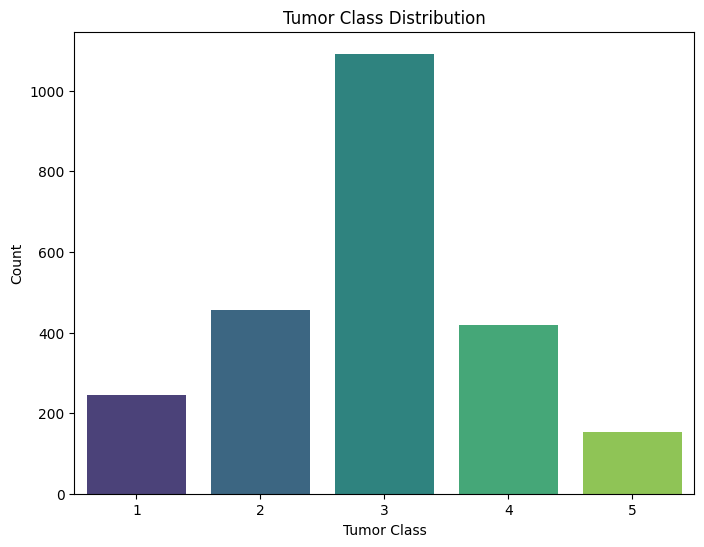

In [103]:
class_counts = dataset['TumorClass'].value_counts()
print("\nClass Distribution:")
print(class_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Tumor Class Distribution")
plt.xlabel("Tumor Class")
plt.ylabel("Count")
plt.show()

In [105]:
def load_nrrd_file(file_name):
    file_path = os.path.join(data_path, file_name)
    data, header = nrrd.read(file_path)
    return data

### Visualize some samples

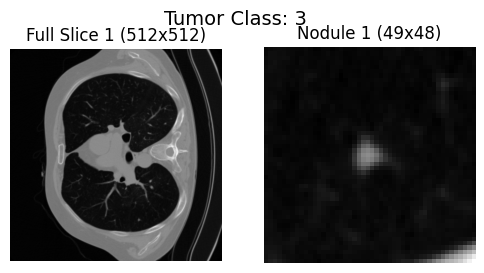

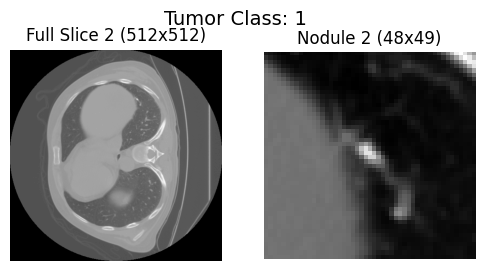

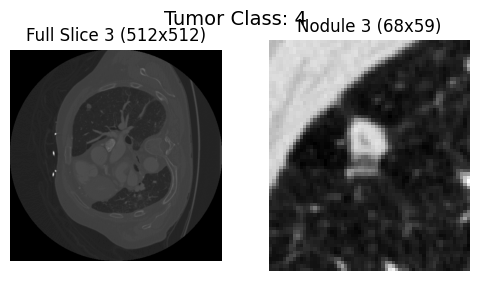

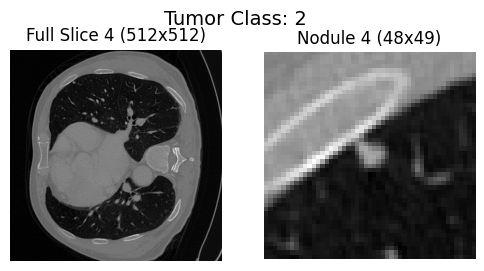

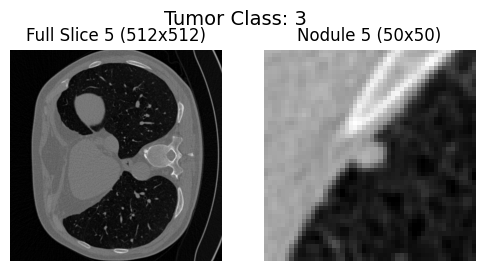

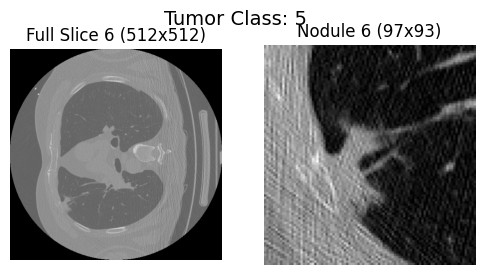

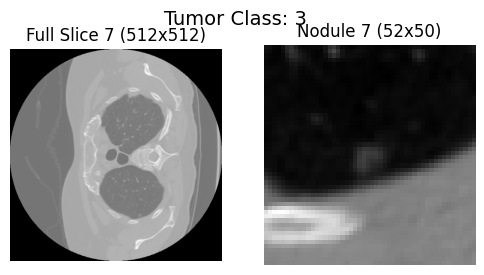

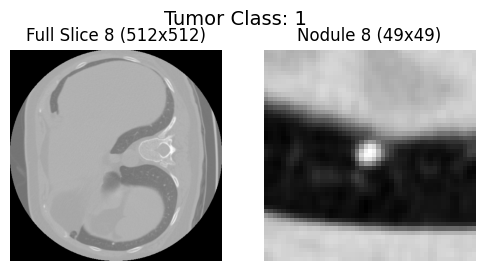

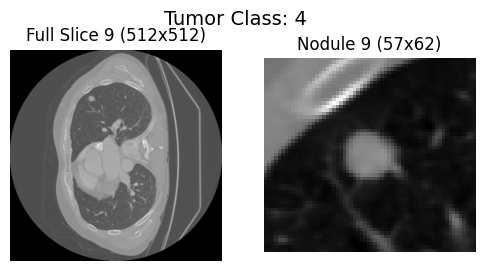

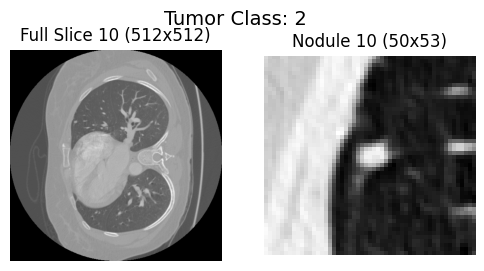

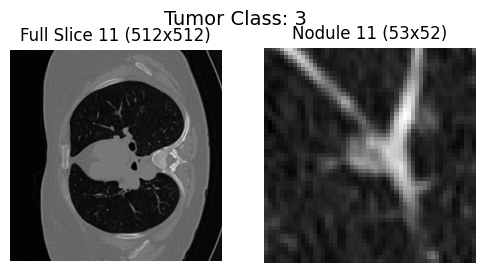

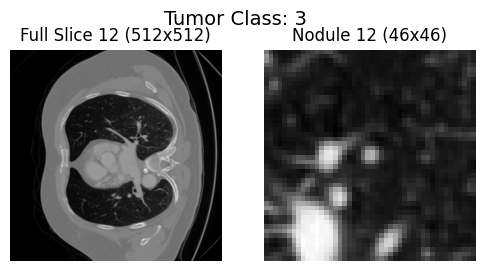

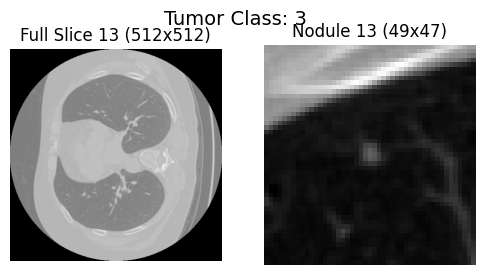

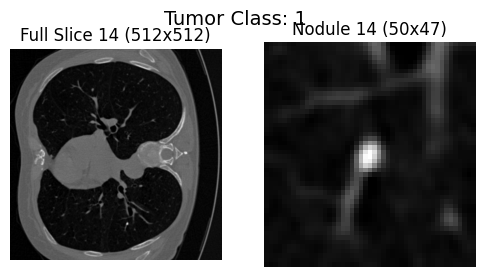

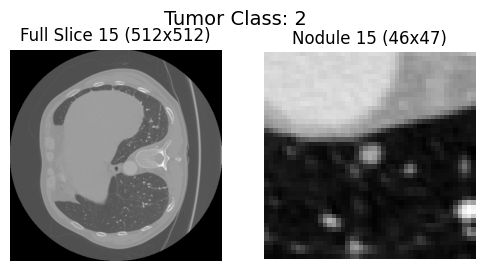

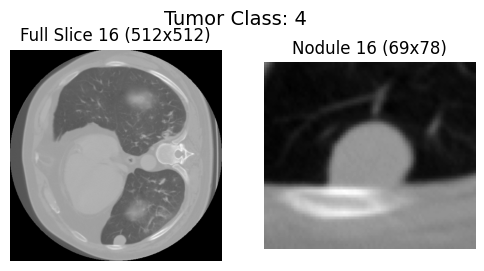

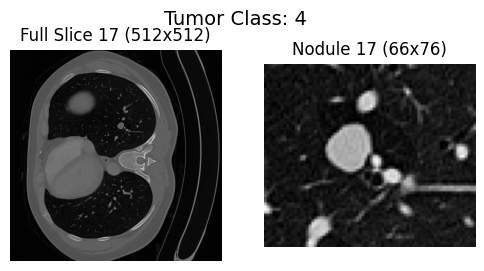

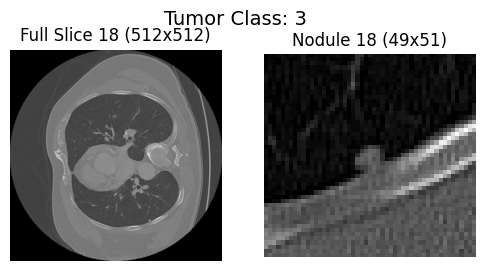

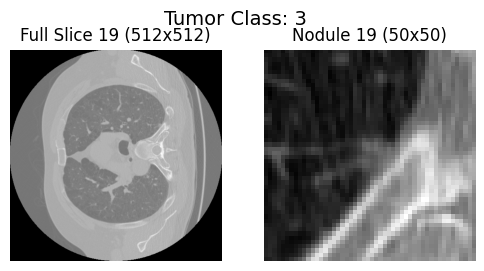

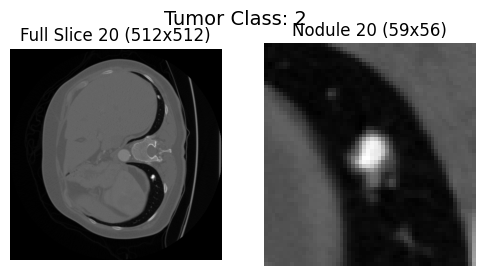

In [43]:
image_dir = "/kaggle/input/lung-tumor-ds/Train"

random_samples = dataset.sample(20)

for i, (_, row) in enumerate(random_samples.iterrows()):
    full_slice_path = os.path.join(image_dir, row['Full_slice'])
    nodule_path = os.path.join(image_dir, row['Nodule'])

    # Load the images
    full_slice = load_nrrd(full_slice_path)
    nodule = load_nrrd(nodule_path)

    # Visualize the images
    if full_slice is not None and nodule is not None:
        plt.figure(figsize=(6, 3))

        # Check dimensions and handle appropriately for full_slice
        full_slice_2d = full_slice[0] if len(full_slice.shape) > 2 else full_slice
        plt.subplot(1, 2, 1)
        plt.imshow(full_slice_2d, cmap="gray")
        plt.title(f"Full Slice {i+1} ({full_slice_2d.shape[0]}x{full_slice_2d.shape[1]})")
        plt.axis("off")

        # Check dimensions and handle appropriately for nodule
        nodule_2d = nodule[0] if len(nodule.shape) > 2 else nodule
        plt.subplot(1, 2, 2)
        plt.imshow(nodule_2d, cmap="gray")
        plt.title(f"Nodule {i+1} ({nodule_2d.shape[0]}x{nodule_2d.shape[1]})")
        plt.axis("off")

        plt.suptitle(f"Tumor Class: {row['TumorClass']}", fontsize=14)
        plt.show()

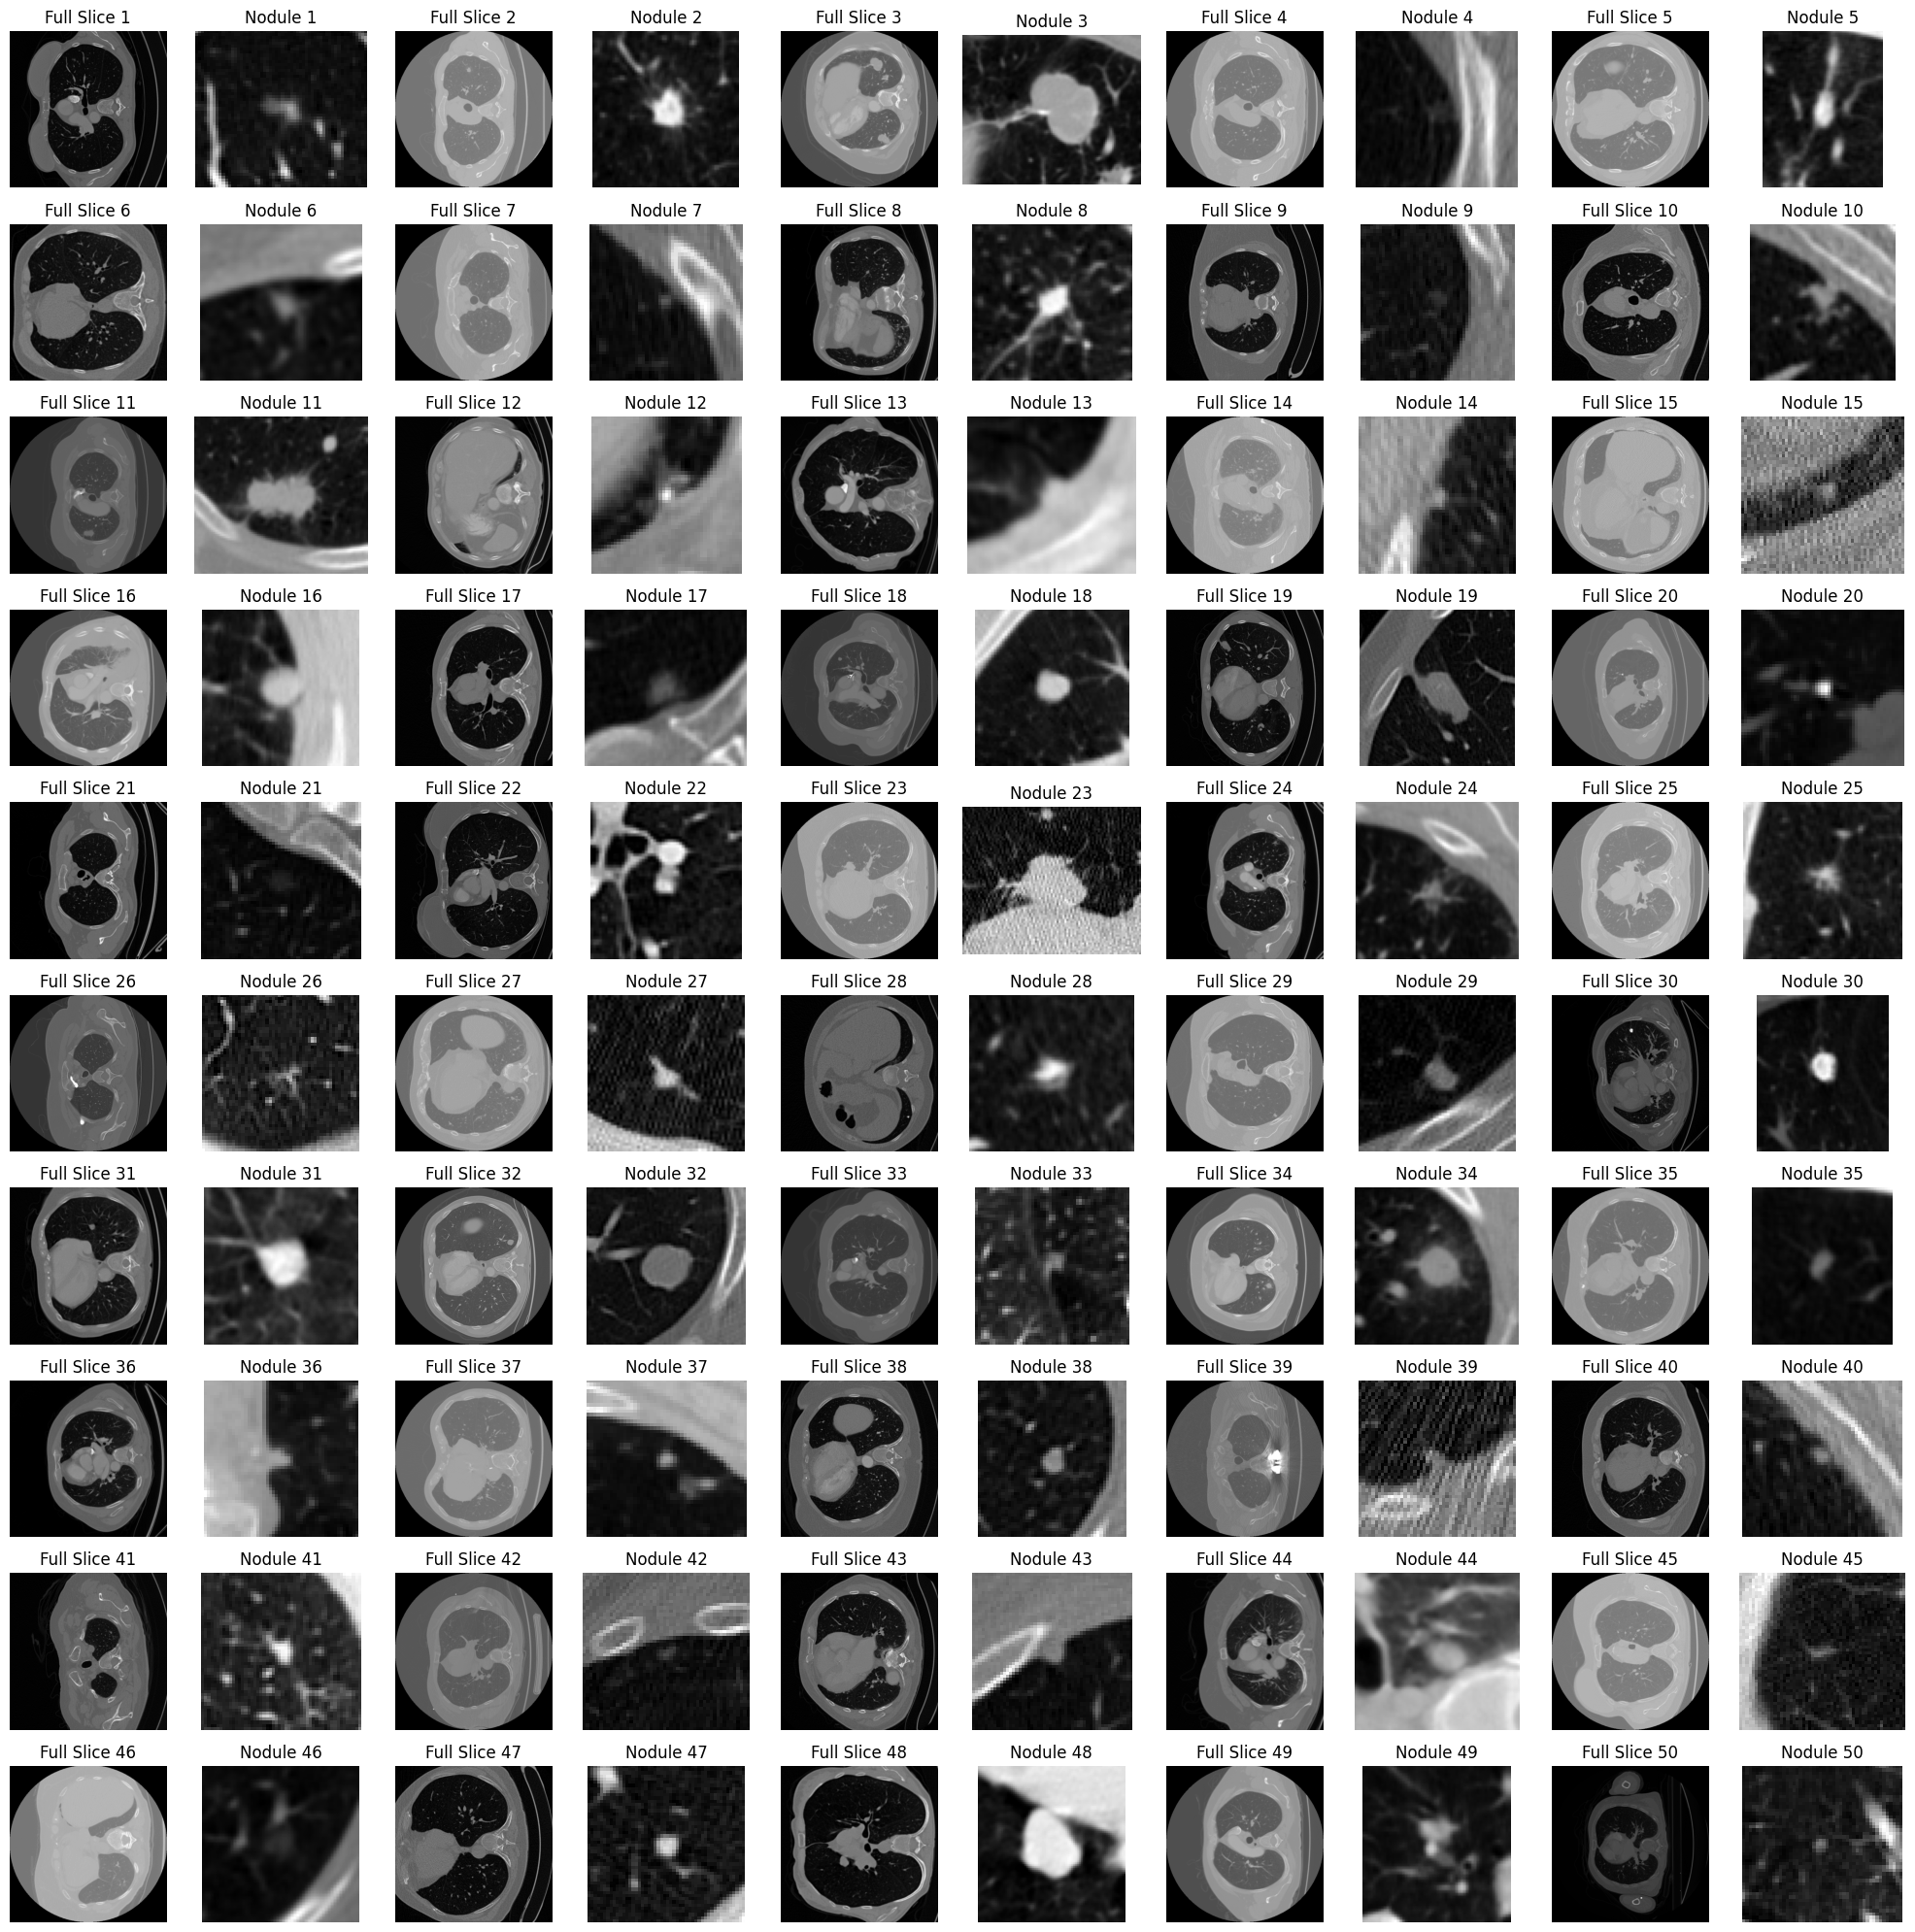

In [44]:
def display_coarse_samples(dataset, image_dir, n_samples=50, n_cols=10):
    # Select n_samples randomly from the dataset
    sampled_data = dataset.sample(n_samples)

    # Adjust the number of rows based on the number of samples and columns
    n_rows = int(np.ceil(n_samples * 2 / n_cols))  # 2 images per sample (Full Slice and Nodule)

    # Create a plot with n_cols columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

    # Flatten axes for easy indexing
    axes = axes.flatten()

    idx = 0
    for _, row in sampled_data.iterrows():
        full_slice_path = os.path.join(image_dir, row['Full_slice'])
        nodule_path = os.path.join(image_dir, row['Nodule'])

        # Load images
        full_slice = load_nrrd(full_slice_path)
        nodule = load_nrrd(nodule_path)

        if full_slice is not None and nodule is not None:
            full_slice_2d = full_slice[0] if len(full_slice.shape) > 2 else full_slice
            nodule_2d = nodule[0] if len(nodule.shape) > 2 else nodule

            # Plot Full Slice
            axes[idx].imshow(full_slice_2d, cmap="gray")
            axes[idx].axis("off")
            axes[idx].set_title(f"Full Slice {idx // 2 + 1}")
            idx += 1

            # Plot Nodule
            axes[idx].imshow(nodule_2d, cmap="gray")
            axes[idx].axis("off")
            axes[idx].set_title(f"Nodule {idx // 2 + 1}")
            idx += 1

    # Hide any unused axes
    for i in range(idx, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

display_coarse_samples(dataset, image_dir, n_samples=50, n_cols=10)

### Load data

In [107]:
full_slices = []
nodule_slices = []
labels = []

for idx, row in dataset.iterrows():
    full_slice_path = os.path.join(image_dir, row['Full_slice'])
    nodule_path = os.path.join(image_dir, row['Nodule'])
    label = row['TumorClass']

    # Load full slice
    try:
        full_slice = load_nrrd(full_slice_path)
        nodule = load_nrrd(nodule_path)

        # Append data
        full_slices.append(full_slice)
        nodule_slices.append(nodule_path)
        labels.append(label)
    except Exception as e:
        print(f"Error loading {full_slice_name} or {nodule_name}: {e}")

### t-SNE analysis on pixel intensities to look for representative clusters

In [127]:
full_slices = np.array(full_slices)
nodule_slices = np.array(nodule_slices)
labels = np.array(labels)

avg_pixel_intensities = [np.mean(img) for img in full_slices]

features = full_slices.reshape(full_slices.shape[0], -1)

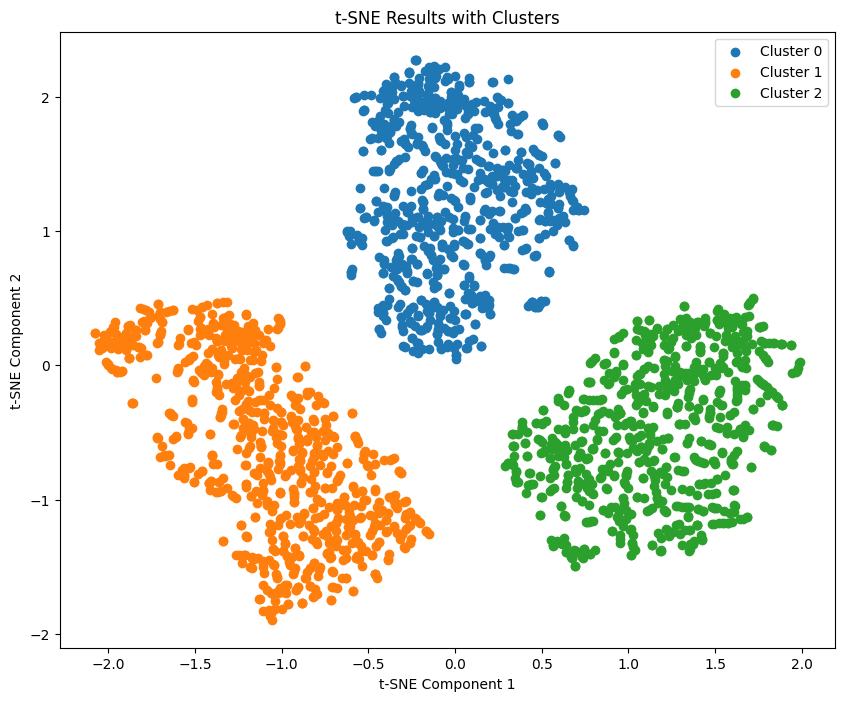

In [129]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Normalize t-SNE results
scaler = StandardScaler()
tsne_results_scaled = scaler.fit_transform(tsne_results)

# Step 5: Clustering using DBSCAN
clustering = DBSCAN(eps=0.3, min_samples=5).fit(tsne_results_scaled)
clusters = clustering.labels_

# Step 6: Visualization of t-SNE outcome
plt.figure(figsize=(10, 8))
for cluster_label in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    plt.scatter(tsne_results_scaled[cluster_indices, 0], tsne_results_scaled[cluster_indices, 1], label=f"Cluster {cluster_label}")

plt.title("t-SNE Results with Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

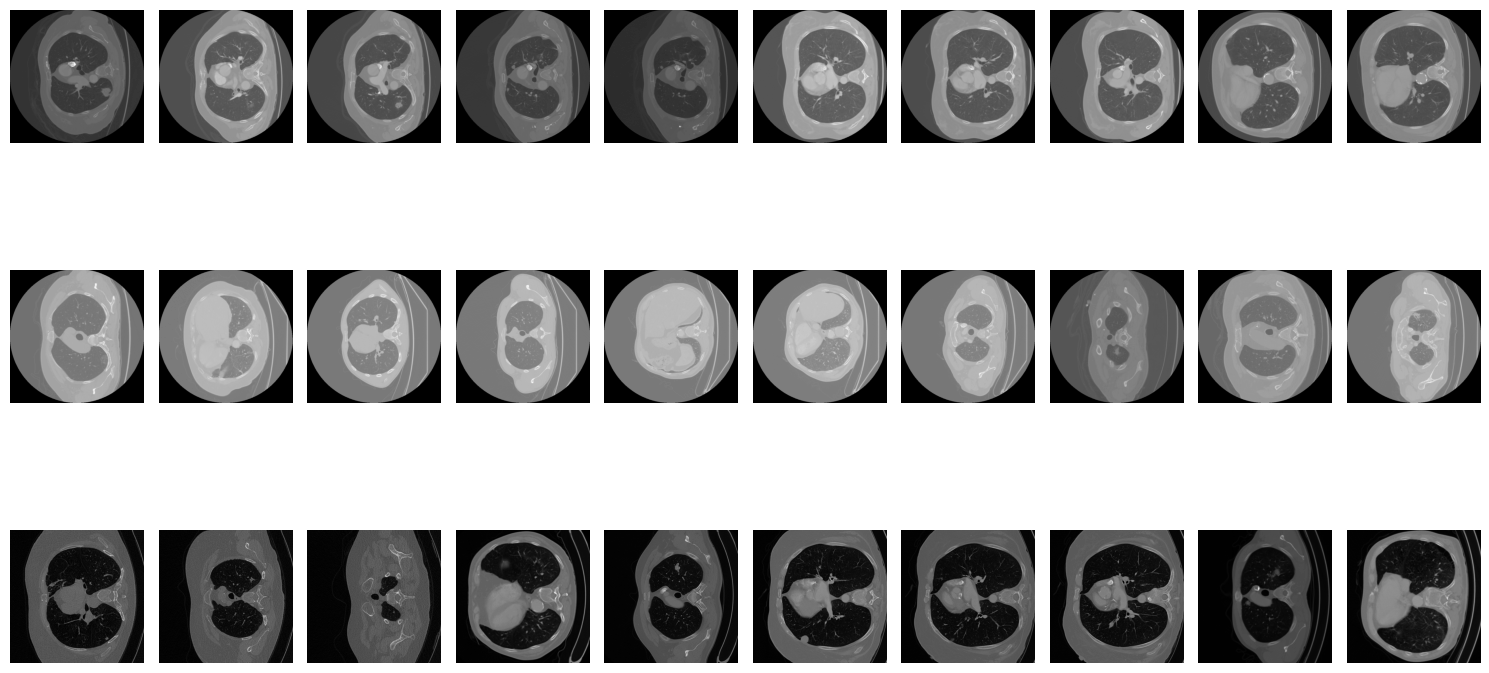

In [130]:
unique_clusters = np.unique(clusters)

fig, axes = plt.subplots(len(unique_clusters), 10, figsize=(15, len(unique_clusters)*3))
for cluster_idx, cluster_label in enumerate(unique_clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]

    # Plot up to 10 images for this cluster
    for i, img_idx in enumerate(cluster_indices[:10]):
        ax = axes[cluster_idx, i]
        ax.imshow(full_slices[img_idx], cmap='gray')
        ax.axis('off')

plt.tight_layout()
plt.show()